<a href="https://colab.research.google.com/github/KaveenAmarasekara/Intellihack_RedHawk_Task01/blob/main/notebooks/intellihack_task01_rain_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Forecasting for Smart Agriculture
This project aims to predict whether it will rain or not based on historical weather data. The dataset includes features like temperature, humidity, and wind speed.

In [80]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [81]:
# Step 2: Load the Dataset
url = "https://raw.githubusercontent.com/KaveenAmarasekara/Intellihack_RedHawk_Task01/refs/heads/main/data/weather_data.csv"

#df = pd.read_csv('file') #you can replace this with your local file or use the url
df = pd.read_csv(url)
df.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331


In [82]:
# Step 3: Data Preprocessing
# Check for missing values
print(df.isnull().sum())

date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64


In [83]:
# # Fill missing values with the mean
# df.fillna(df.mean(), inplace=True)

In [84]:
print(df.dtypes)

date                object
avg_temperature    float64
humidity           float64
avg_wind_speed     float64
rain_or_not         object
cloud_cover        float64
pressure           float64
dtype: object


In [85]:
df['date'] = pd.to_datetime(df['date'])

In [86]:
df['rain_or_not'] = df['rain_or_not'].map({'Rain': 1, 'No Rain': 0})

In [87]:
#since 'date' and 'rain_or_not' were non-numerics we had to change them to a relavant type to refill null values...

In [88]:
# Fill missing values with the mean (retry)
df.fillna(df.mean(), inplace=True)

In [89]:
print(df.dtypes)

date               datetime64[ns]
avg_temperature           float64
humidity                  float64
avg_wind_speed            float64
rain_or_not                 int64
cloud_cover               float64
pressure                  float64
dtype: object


In [90]:
df.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331


In [91]:
# Check for missing values
print(df.isnull().sum())

date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
dtype: int64


In [92]:
## no null values on second checking

In [93]:
# Step 1: Identify numeric columns
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
print("Numeric columns:", numeric_columns)

Numeric columns: Index(['avg_temperature', 'humidity', 'avg_wind_speed', 'rain_or_not',
       'cloud_cover', 'pressure'],
      dtype='object')


In [94]:
## now checking for any negative values in above columns

In [95]:
for column in numeric_columns:
    negative_values = df[column][df[column] < 0]  # Filter rows with negative values
    if not negative_values.empty:
        print(f"\nColumn '{column}' has {len(negative_values)} negative values:")
        print(negative_values)

In [96]:
# seems there is no negative values.

In [97]:
# Now we extract day of the week and month from date and make separate columns for future use if needed
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# Drop
df.drop('date', axis=1, inplace=True)

In [98]:
print(df.dtypes)
df.head()

avg_temperature    float64
humidity           float64
avg_wind_speed     float64
rain_or_not          int64
cloud_cover        float64
pressure           float64
day_of_week          int32
month                int32
dtype: object


,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,day_of_week,month
0,23.745401,46.140905,7.845981,1,20.851051,992.965681,6,1
1,30.030503,59.876587,5.382457,1,93.059521,1037.273025,0,1
2,28.365224,51.464618,13.158008,1,11.636640,1034.193357,1,1
3,27.550929,53.103799,5.886677,1,81.744971,968.610142,2,1
4,23.639303,57.826186,12.248992,1,38.062329,1030.264331,3,1


In [99]:
print(df.isnull().sum())

avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
day_of_week        0
month              0
dtype: int64


In [100]:
# no errors with new columns

In [101]:
# Normalize
scaler = StandardScaler()
df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']] = scaler.fit_transform(df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']])

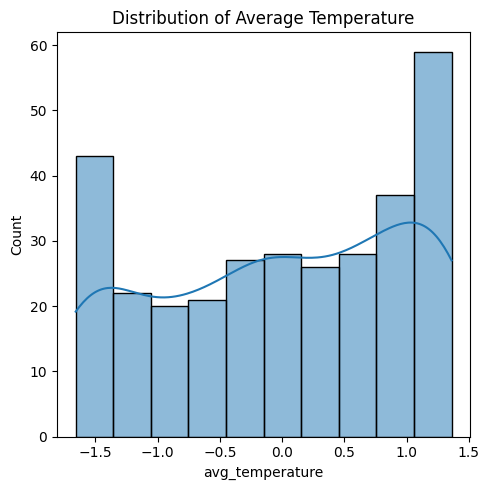

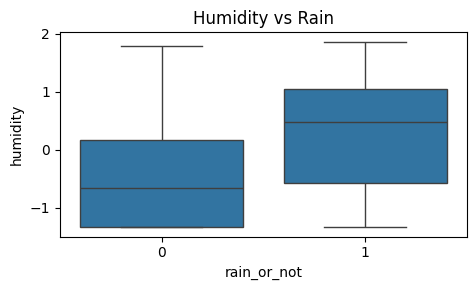

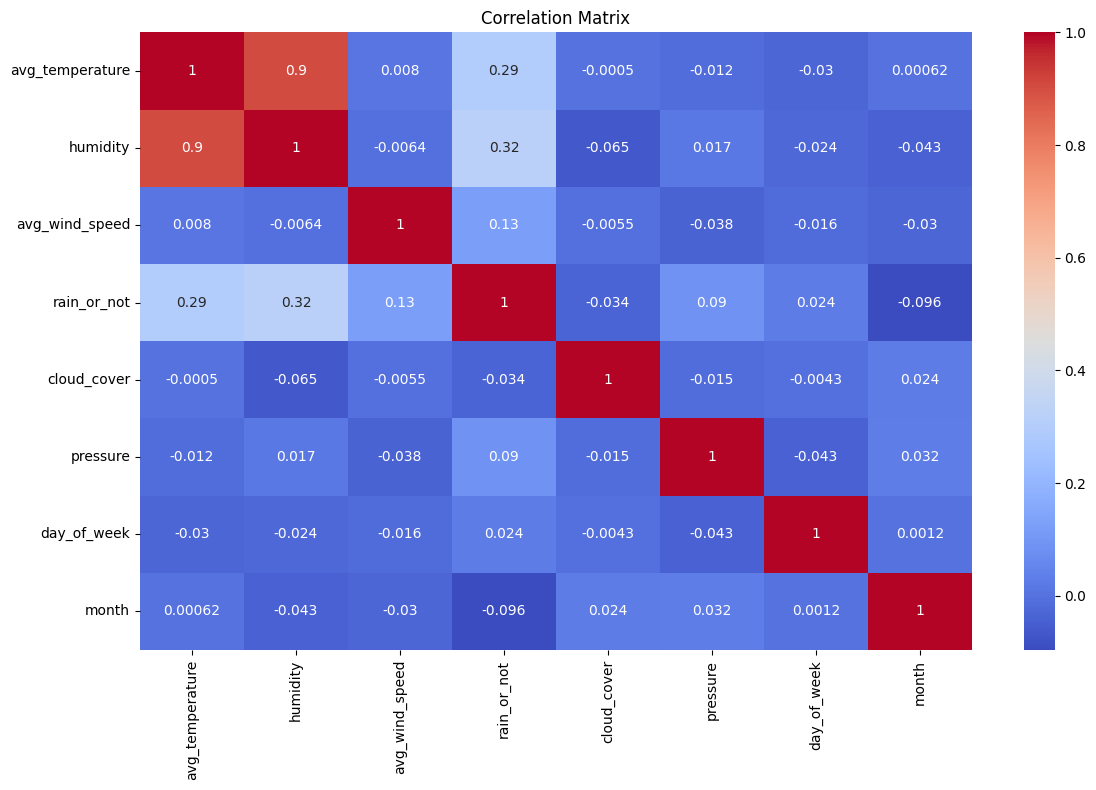

In [102]:
# Step 4: (EDA) >> plot graphs

# Distribution of avg_temperature
plt.figure(figsize = (5, 5))
sns.histplot(df['avg_temperature'], kde=True) # Univariate Analysis
plt.title('Distribution of Average Temperature')
plt.tight_layout()
plt.show()

# Humidity vs Rain
plt.figure(figsize = (5, 3))
sns.boxplot(x='rain_or_not', y='humidity', data=df) # Bivariate Analysis
plt.title('Humidity vs Rain')
plt.tight_layout()
plt.show()

# Correlation Analysis
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [103]:
# Split the data into features (X) and target (y)
X = df.drop('rain_or_not', axis=1)
y = df['rain_or_not']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
# Train a Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

In [105]:
# Evaluate Logistic Regression
print("Logistic Regression Metrics:\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg)}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg)}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg)}")
print(f"ROC-AUC: {roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])}")


Logistic Regression Metrics:

Accuracy: 0.6666666666666666
Precision: 0.7272727272727273
Recall: 0.7804878048780488
F1-Score: 0.7529411764705882
ROC-AUC: 0.6031042128603105


In [106]:
# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [107]:
# Evaluate Random Forest
print("\nRandom Forest Metrics:\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf)}")
print(f"ROC-AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])}")


Random Forest Metrics:

Accuracy: 0.5873015873015873
Precision: 0.6923076923076923
Recall: 0.6585365853658537
F1-Score: 0.675
ROC-AUC: 0.6047671840354768


In [108]:
# Step 6: Model Optimization
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("\nBest Parameters for Random Forest:", grid_search.best_params_)


Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [109]:
# Train the optimized model
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

In [110]:
# Evaluate the optimized model
print("\nOptimized Random Forest Metrics:\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_best_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_best_rf)}")
print(f"F1-Score: {f1_score(y_test, y_pred_best_rf)}")
print(f"ROC-AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])}")


Optimized Random Forest Metrics:

Accuracy: 0.6031746031746031
Precision: 0.6904761904761905
Recall: 0.7073170731707317
F1-Score: 0.6987951807228916
ROC-AUC: 0.6119733924611973


Hard coded future dataset

In [111]:
# Step 7: Final Output
# Generate predictions for the next 21 days (example)
future_data = pd.DataFrame({
    'avg_temperature': [20, 22, 19, 30],
    'humidity': [60, 65, 70, 40],
    'avg_wind_speed': [10, 12, 11, 10],
    'cloud_cover': [50, 55, 60, 45],
    'pressure': [1010, 1012, 1011, 1010],
    'day_of_week': [1, 2, 3, 2],
    'month': [6, 6, 6, 1]
})

# Scale future data
future_data[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']] = scaler.transform(future_data[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']])

# Predict probabilities
future_predictions = best_rf.predict_proba(future_data)[:, 1]
print("\nRain Probability for Future Data:")
print(future_predictions)

# Save predictions to a CSV file
pd.DataFrame(future_predictions, columns=['rain_probability']).to_csv('future_predictions.csv', index=False)


Rain Probability for Future Data:
[0.57986583 0.63571444 0.65036607 0.57237351]


Handle a future data set (from a file)

In [112]:
# Step 1: Load the future data from CSV
url = "https://raw.githubusercontent.com/KaveenAmarasekara/Intellihack_RedHawk_Task01/refs/heads/main/data/future_data.csv"
# future_data = pd.read_csv('file') #you can replace this with your local file or use the url
future_data = pd.read_csv(url)
future_data.head()

,date,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure
0,2025-03-10,20,60,10,50,1010
1,2025-03-12,22,65,12,55,1012
2,2025-03-13,19,70,11,60,1011
3,2025-03-20,31,50,11,55,1011
4,2025-03-25,29,45,14,45,1012


In [113]:
print(future_data.isnull().sum())

date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
cloud_cover        0
pressure           0
dtype: int64


In [114]:
print(future_data.dtypes,"\n")
future_data.head()
future_data['date'] = pd.to_datetime(future_data['date'])

# Step 2: Handle missing values (if any)
# Fill missing values with the mean of each column
future_data.fillna(future_data.mean(), inplace=True)

# Step 3: Handle incorrect entries (e.g., negative values)
# Replace negative values with the column mean
for column in future_data.select_dtypes(include=['int', 'float']).columns:
    future_data[column] = future_data[column].apply(lambda x: x if x >= 0 else future_data[column].mean())

future_data['date'] = pd.to_datetime(future_data['date'])

future_data['day_of_week'] = future_data['date'].dt.dayofweek
future_data['month'] = future_data['date'].dt.month

# Drop
future_data.drop('date', axis=1, inplace=True)
print(future_data.dtypes)
future_data.head()



date               object
avg_temperature     int64
humidity            int64
avg_wind_speed      int64
cloud_cover         int64
pressure            int64
dtype: object 

avg_temperature    int64
humidity           int64
avg_wind_speed     int64
cloud_cover        int64
pressure           int64
day_of_week        int32
month              int32
dtype: object


,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure,day_of_week,month
0,20,60,10,50,1010,0,3
1,22,65,12,55,1012,2,3
2,19,70,11,60,1011,3,3
3,31,50,11,55,1011,3,3
4,29,45,14,45,1012,1,3


In [115]:
# Step 4: Scale the future data (if scaling was applied to training data)
# Load the scaler used for training data (or fit a new one)
scaler = StandardScaler()
# Assuming the training data was scaled, fit the scaler on the training data
# For example, if X_train was used for scaling:
# scaler.fit(X_train)

# Scale the future data

scaler = StandardScaler()
future_data[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']] = scaler.fit_transform(future_data[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']])


# Convert back to DataFrame (optional)
future_data_scaled = pd.DataFrame(future_data, columns=future_data.columns)

# Step 5: Verify the preprocessed future data
print("Preprocessed Future Data:")
future_data_scaled.head()

Preprocessed Future Data:


,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure,day_of_week,month
0,-0.861640,0.215666,-1.179536,-0.588348,-1.603567,0,3
1,-0.451335,0.754829,0.294884,0.392232,1.069045,2,3
2,-1.066793,1.293993,-0.442326,1.372813,-0.267261,3,3
3,1.395037,-0.862662,-0.442326,0.392232,-0.267261,3,3
4,0.984732,-1.401826,1.769303,-1.568929,1.069045,1,3


In [116]:
# Assuming you have a trained model (e.g., Random Forest)
predictions = best_rf.predict_proba(future_data_scaled)[:, 1]  # Probability of rain

# Save predictions to a CSV file
pd.DataFrame(predictions, columns=['rain_probability']).to_csv('future_predictions.csv', index=False)

print("Rain Probabilities for Future Data:")
print(predictions)

Rain Probabilities for Future Data:
[0.389375   0.64371937 0.62436538 0.54887379 0.69740196]
